In [1]:
import numpy as np
np.random.seed(42)
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from scipy.misc import face
from scipy.linalg import norm
from skimage import measure
import skimage
from scipy.ndimage import filters as fi
import networkx as nx
from sklearn import cluster
import threading
import Queue
import time
from multiprocessing import cpu_count
import cv2
import os 

In [2]:
#project_path = "C:\Users\H\Documents\Japet\Cours\ML\Projet"
project_path = "/home/alex/Documents/MLFTTP/projet/Patch-Match"

psi_min = 21
psi_max = 101

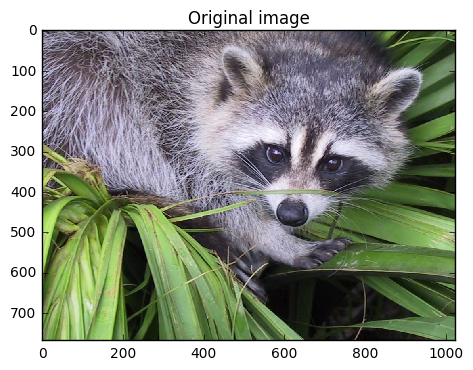

The dim of the image is (768, 1024, 3)


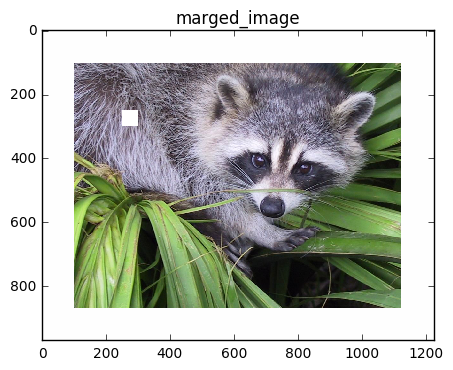

The dim of the image is (970, 1226, 3)


In [3]:
#initialisation of pictures

#imgpath = os.path.join(project_path, "ressources", "withoutjumper.npy")
#img = np.load(imgpath)

img = face()
img.reshape((img.shape[0], img.shape[1], -1))
plt.gray()
plt.imshow(img, interpolation='none', norm=Normalize(vmin=0, vmax=255))
plt.title("Original image")
plt.show()
print 'The dim of the image is ' + str(img.shape)

shape = img.shape[2]
#Create a hole
marged_img = (np.zeros((img.shape[0] + 2 * psi_max, img.shape[1] + 2 * psi_max, shape)) - 2).astype(int)
marged_img[psi_max: - psi_max, psi_max:-psi_max] = img.astype(int).copy()

#marged_img[(marged_img[:,:,0]==0) * (marged_img[:,:,1]==0) * (marged_img[:,:,2]==0)] = - np.ones(shape)
marged_img[250:300, 250:300] = - np.ones(shape)

plt.imshow(marged_img.astype(np.uint8), interpolation='none', norm=Normalize(vmin=0, vmax=255))
plt.title("marged_image")
plt.show()
print 'The dim of the image is ' + str(marged_img.shape)

In [4]:
#Needed variables
#Create indicator for best match, in order to not reuse applied patch as true patch
indicator = np.ones((marged_img.shape[0], marged_img.shape[1]))
indicator[marged_img[:,:,0]==-1]=-1
indicator[marged_img[:,:,0]==-2]=-1

#Create the confidence matrix
confidence = np.ones((marged_img.shape[0], marged_img.shape[1]))
confidence[marged_img[:,:,0]==-1]=0
confidence[marged_img[:,:,0]==-2]=0

In [ ]:
#All needed functions

#find priority term
def confidence_coefficient(confidence, pt, psi=9):
    result = 0
    for i in range(psi):
        for j in range(psi):
            result += confidence[np.int(pt[0] + i - (psi-1)/2+0.5), np.int(pt[1] + j - (psi-1)/2 +0.5)]
    return float(result)/psi**2

#Normal vector to the contour
def gen_normal_vector(omega):
    tangeantes = [(omega[i+1][0] - omega[i-1][0],omega[i+1][1] - omega[i-1][1]) for i in range(1, len(omega)-1)]
    normals = [(-j/np.sqrt(i*i+j*j), i/np.sqrt(i*i+j*j)) for i,j in tangeantes]
    return normals 

#Creation of the data coefficient
def gen_data_vector(normal, isophote, alpha=255.):
    result = [np.abs(normal[i][0] * isophote[i][0] + normal[i][1] * isophote[i][1])/alpha for i in range(len(isophote))]
    return result

#Create a 3d norm
def norm3d(img, param):
    temp = img.reshape((img.shape[0], img.shape[1], -1))
    shape = temp.shape[2]
    result = 0
    for i in range(shape):
        result += norm(img[:, :, i], param)
    return result

#Create a distance which takes into account the distance to a hole
def distance(img1, img2, is_compared, gauss, param = 2):
    temp = img1.reshape((img1.shape[0], img1.shape[1], -1))
    shape = temp.shape[2]
    result = 0

    for i in range(shape):
        result += norm((img1[:, :, i] - img2[:, :, i]) * gauss, param)
    return result

def create_kernel_local(xc, yc):
    result = np.zeros((psi, psi))
    for i in range(psi):
        for j in range(psi):
            result[i,j] = float((i-xc)**2 + (j-yc)**2) / 2
    m = np.max(result)        
    result = 1 - result.astype(np.float) / m
    return result

def create_kernel_patch(is_compared):
    result = np.zeros(is_compared.shape)
    counter = 0
    for i in range(is_compared.shape[0]):
        for j in range(is_compared.shape[1]):
            if is_compared[i,j] == 0:
                result += create_kernel_local(i, j)
                counter += 1
    result = result.astype(np.float) / counter
    return result

#Find best match without parallelism for debugging
def find_best_match(patch, img, indicator, is_compared, patch_x, patch_y, psi=9):
    result = 99999
    result_x = 0
    result_y = 0
    patch_comp = patch * is_compared
    gauss = create_kernel_patch(is_compared[:, :, 0])
    for i in range(psi, img.shape[0]-psi+1):
        for j in range(psi, img.shape[1]-psi+1):
            #print(i, j)
            img_comp = img[i - psi/2: i + psi/2+1, j - psi/2: j + psi/2+1].copy()
            if np.all(img_comp != -1):
                img_comp *= is_compared
                #print(img_comp.shape)
                if distance(img_comp, patch_comp, is_compared[:, :, 0], gauss) < result:
                    result = distance(img_comp, patch_comp, is_compared[:, :, 0], gauss)
                    result_x = i
                    result_y = j
    return result_x, result_y

#Find the right contour in the picture
def find_good_contour(contours, img):
    for contour in contours:
        pt = contour[len(contour)/2]
        pt = [int(i) for i in pt]
        if np.any(img[pt[0]-1:pt[0]+2, pt[1]-1:pt[1]+2]==[-1,-1,-1]) :
            contour = np.concatenate((np.array([contour[0]]), contour, np.array([contour[-1]])))
            contour = contour+0.5
            return True, contour
    return False, []

#Find the maximal value in temp
def pooling(temp):
    return np.max(np.abs(temp))

#Compute the gradient of a patch with a hole in it
def get_isophote(pts, img, psi=9):
    isophote = []
    for pt in pts:
        x = pt[0]
        y = pt[1]
        temp = img[np.int(x - psi/2): np.int(x + psi/2+1), np.int(y - psi/2): np.int(y + psi/2+1)]
        grad = np.gradient(np.ma.masked_where(temp == -1, temp))
        isophote.append((pooling(grad[0]), pooling(grad[1])))
    return isophote

#Small usefull function
def should_be_connected(n1, n2):
    if (len(n1) == 2) & (len(n2) == 2):
        return( ((n1[0]-n2[0])**2 + (n1[1]-n2[1])**2) == 1 )
    else:
        raise NameError("Wrong node")
        
def is_inter(i, pt, psi=9):
    return (i>pt - psi/2-1) & (i<pt + psi/2+1)

def tuple_add(pt1, pt2):
    return (int(pt1[0] + pt2[0]), int(pt1[1] + pt2[1]))

def tuple_minus(pt1, pt2):
    return (pt1[0] - pt2[0], pt1[1] - pt2[1])

def edge_weight(pt1_ini, pt2_ini, old_patch, new_patch, demi=False):
    
    if demi:
        diff = tuple_minus(pt2_ini, pt1_ini)

        pt1 = (int(pt1_ini[0]), int(pt1_ini[1]))
        pt2 = tuple_add(pt2_ini, diff)
    else:
        pt1 = (int(pt1_ini[0]), int(pt1_ini[1]))
        pt2 = (int(pt2_ini[0]), int(pt2_ini[1]))
    
    return norm3d(old_patch[pt1].reshape((1, 1, -1))-new_patch[pt1].reshape((1, 1, -1)), 2) + \
        norm3d(old_patch[pt2].reshape((1, 1, -1))-new_patch[pt2].reshape((1, 1, -1)), 2)
        
def tuple_in(t, l):
    return (t in l) | ((t[1], t[0]) in l)

#Transform the patch probleme into a graph
def create_graph(img_ini, pt_ini, new_patch, cut_edges, psi=9):
    img = img_ini.reshape((img_ini.shape[0], img_ini.shape[1], -1))
    pt = (int(pt_ini[0] + 0.5), int(pt_ini[1] + 0.5))
    old_patch = img[pt[0] - psi/2 - 1: pt[0] + psi/2 + 2, pt[1] - psi/2 - 1: pt[1] + psi/2 + 2]
    G=nx.Graph()
    G.add_node("old")
    G.add_node("new")
    for i in range(pt[0] - psi/2, pt[0] + psi/2+1):
        firsti = (i == pt[0] - psi/2)
        lasti = (i == pt[0] + psi/2)
        for j in range(pt[1] - psi/2, pt[1] + psi/2+1):
            firstj = (j == pt[1] - psi/2)
            lastj = (j == pt[1] + psi/2)
            if img[i, j, 0] != -1:
                G.add_node((i, j))
                if not firsti:
                    if ((img[i-1, j, 0] == -1) & ((i-1, j) not in G.nodes())):
                        G.add_node((i-1, j))
                        G.add_edge((i-1, j), 'new', weight=np.inf)
                else:
                    G.add_node((i-1, j))
                    G.add_edge((i-1, j), 'old', weight=np.inf)
                if not lasti:
                    if ((img[i+1, j, 0] == -1) & ((i+1, j) not in G.nodes())):
                        G.add_node((i+1, j))
                        G.add_edge((i+1, j), 'new', weight=np.inf)
                else:
                    G.add_node((i+1, j))
                    G.add_edge((i+1, j), 'old', weight=np.inf)
                if not firstj:
                    if ((img[i, j-1, 0] == -1) & ((i, j-1) not in G.nodes())):
                        G.add_node((i, j-1))
                        G.add_edge((i, j-1), 'new', weight=np.inf)
                else:
                    G.add_node((i, j-1))
                    G.add_edge((i, j-1), 'old', weight=np.inf)
                if not lastj:
                    if ((img[i, j+1, 0] == -1) & ((i, j+1) not in G.nodes())):
                        G.add_node((i, j+1))
                        G.add_edge((i, j+1), 'new', weight=np.inf)
                else:
                    G.add_node((i, j+1))
                    G.add_edge((i, j+1), 'old', weight=np.inf)
                    
                for ibis, jbis in [(i-1, j), (i+1,j), (i, j-1), (i, j+1)]:
                    if (not tuple_in(((i,j), (ibis, jbis)), G.edges())) & ((ibis,jbis) in G.nodes()):
                        if ((i,j), (ibis, jbis)) in cut_edges:
                            idemi, jdemi = (float(i+ibis)/2, float(j+jbis)/2)
                            G.add_node((idemi, jdemi))
                            G.add_edge((idemi,jdemi), 'new', cut_edges)
                            G.add_edge((i, j), (idemi, jdemi), weight=edge_weight((i - pt[0] + psi/2 + 1, j - pt[1] + psi/2 + 1), 
                                                                 (idemi - pt[0] + psi/2 + 1, jdemi - pt[1] + psi/2 + 1),
                                                                 old_patch, new_patch, demi=True))
                            G.add_edge((ibis, jbis), (idemi, jdemi), weight=edge_weight((ibis - pt[0] + psi/2 + 1, jbis - pt[1] + psi/2 + 1), 
                                                                 (idemi - pt[0] + psi/2 + 1, jdemi - pt[1] + psi/2 + 1),
                                                                 old_patch, new_patch, demi=True))
                        else:
                            G.add_edge((ibis, jbis), (i,j), weight=edge_weight((i - pt[0] + psi/2 + 1, j - pt[1] + psi/2 + 1), 
                                                                     (ibis - pt[0] + psi/2 + 1, jbis - pt[1] + psi/2 + 1),
                                                                     old_patch, new_patch))
    return G

#Find edge which have been cut
def find_cut_edges(G, set_old, dico_cut_edges):
    for edge in G.edges(data=True):
        node1 = edge[0]
        node2 = edge[1]
        if (node1!='old') & (node1!='new') & (node2!='old') & (node2!='new'):
            if ((node1 in set_old) & (node2 not in set_old)) | ((node1 not in set_old) & (node2 in set_old)):
                if np.floor(node1[0]) != node1[0]:
                    node1 = (2 * node1[0] - node2[0], node1[1])
                elif np.floor(node1[1]) != node1[1]:
                    node1 = (node1[0], 2 * node1[1] - node2[1])
                elif np.floor(node2[0]) != node2[0]:
                    node2 = (2 * node2[0] - node1[0], node2[1])
                elif np.floor(node2[1]) != node2[1]:
                    node2 = (node2[0], 2 * node2[1] - node1[1])
                dico_cut_edges[(node1, node2)]= edge[2]["weight"]
                dico_cut_edges[(node2, node1)]= edge[2]["weight"]
    return dico_cut_edges

#Multithreading of findbestmatch
def worker_function(t, queue, img, indicator, is_compared, gauss, patch, psi):
    global result, result_x, result_y
    patch_comp = patch * is_compared
    while True:
        i,j = queue.get()
        if (i<psi/2) | (j<psi/2) | (i>img.shape[0]-psi/2-1) | (j>img.shape[1]-psi/2-1):
            queue.task_done()
        else:
            if queue.qsize()%20000 ==0:
                print("The queue size is %s"%queue.qsize())
            img_comp = img[i - psi/2: i + psi/2+1, j - psi/2: j + psi/2+1].copy()
            ind_comp = indicator[i - psi/2: i + psi/2+1, j - psi/2: j + psi/2+1].copy()
            if np.all(ind_comp != -1):
                img_comp *= is_compared
                #print(img_comp.shape)
                if distance(img_comp, patch_comp, is_compared[:, :, 0], gauss) < result:
                    result = distance(img_comp, patch_comp, is_compared[:, :, 0], gauss)
                    result_x = i
                    result_y = j
            queue.task_done()
        
def findbestmatchmulti(patch, img, indicator, is_compared, patch_x, patch_y, psi=9):
    global result, result_x, result_y
    result = 9999
    main_queue = Queue.Queue()
    for i in range(max(0, int(patch_x - 200)), int(patch_x + 200 + 1)):
            for j in range(max(0, int(patch_y - 200)), int(patch_y + 200 + 1)):
                main_queue.put((i, j))

    num_fetch_threads = cpu_count()
    
    gauss = create_kernel_patch(is_compared[:, :, 0])
    
    for i in range(num_fetch_threads):
        worker = threading.Thread(target=worker_function, args=(i, main_queue, marged_img, indicator, 
                                                                is_compared, gauss, patch, psi))
        worker.setDaemon(True)
        worker.start()

    print '*** Main thread waiting'
    main_queue.join()
    print '*** Done'
    return result_x, result_y

def update_cut_edges(cut_edges, new_set):
    new_cut_edges = {}
    for edge in cut_edges:
        node1 = edge[0]
        node2 = edge[1]
        if (node1 not in new_set) & (node2 not in new_set):
            new_cut_edges[edge]= cut_edges[edge]
    return new_cut_edges

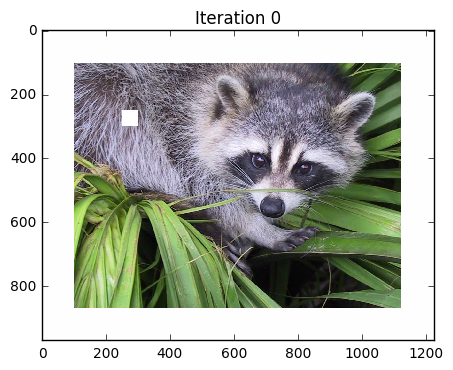

psi = 47
Confidence 0.750113173382
Data 3.49211219607
Priority 2.6194793612


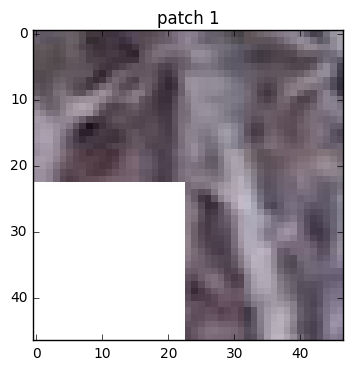

*** Main thread waiting
The queue size is 140000The queue size is 140000

The queue size is 120000
The queue size is 100000
The queue size is 60000The queue size is 60000The queue size is 60000

The queue size is 60000

The queue size is 40000


In [ ]:
#Main loop to fill a first time all holes

time_init = time.time()
contours = measure.find_contours(marged_img[:,:,0], 0.8)
criteria, contour = find_good_contour(contours, marged_img)
nb_iter = 0
cut_edges = {}

while criteria:
    
    if nb_iter%1== 0:
        plt.imshow(marged_img.astype(np.uint8), norm=Normalize(vmin=0, vmax=255), interpolation='none')
        plt.title("Iteration " + str(nb_iter))
        plt.show()
    else:
        print("Iteration " + str(nb_iter))
    nb_iter += 1
    
    psi = np.random.randint(9,51) / 2 * 2 + 1
    
    if True:
        print("psi = %s"%psi)
        
    #Define the contour as tuple
    omega=[(i[0], i[1]) for i in contour]
    
    #Create confidence coefficient for each point
    confidence_vector = [confidence_coefficient(confidence, pt, psi=psi) for pt in omega][1:-1]

    #Compute isophote for each point
    isophote_vector = get_isophote(omega, marged_img)[1:-1]

    #Compute the normal of the border vector for each point
    normal_vector = gen_normal_vector(omega)

    #Compute de data term for each point
    data_vector = gen_data_vector(normal_vector, isophote_vector, alpha=10.)

    #Compute the priority term for each term
    priority_vector = [data_vector[i] * confidence_vector[i] for i in range(len(data_vector))]
    
    #Find the point with the highest priority
    m = max(priority_vector)
    indices = [ i for i,j in enumerate(priority_vector) if j==m]
    indice = indices[len(indices)/2]
    patch_x, patch_y = omega[indice+1]
    
    patch_x = int(patch_x + 0.5)
    patch_y = int(patch_y + 0.5)
    
    if True:
        print("Confidence "+str(confidence_vector[indice]) )
        print("Data "+str(data_vector[indice]))
        print("Priority "+str(priority_vector[indice]))
    
    #create the patch to find
    patch = marged_img[np.int(patch_x - psi/2): np.int(patch_x + psi/2+1), np.int(patch_y - psi/2): np.int(patch_y + psi/2+1)]
    
    if True:
        plt.imshow(patch.astype(np.uint8), norm=Normalize(vmin=0, vmax=255), interpolation='none')
        plt.title("patch " + str(nb_iter))
        plt.show()
    
    #Compute the area to compare between the previous patch and the area on the picture
    is_compared = marged_img[np.int(patch_x - psi/2): np.int(patch_x + psi/2+1), np.int(patch_y - psi/2): np.int(patch_y + psi/2+1)]!=-1
    
    #Find the best match
    result_x, result_y = findbestmatchmulti(patch, marged_img, indicator, is_compared, patch_x, patch_y, psi=psi)
    
    #create the patch to apply
    true_patch = marged_img[result_x - psi/2: result_x + psi/2+1, result_y - psi/2: result_y + psi/2+1].copy()
    enlarged_true_patch = marged_img[result_x - psi/2-1: result_x + psi/2+2,
                                        result_y - psi/2-1: result_y + psi/2+2].copy()
    
    #Create the graph associated
    G = create_graph(marged_img, (patch_x, patch_y), enlarged_true_patch, cut_edges, psi=psi)
    sets = (nx.minimum_cut(G, 'old', 'new', capacity="weight"))
    
    if 'old' in sets[1][0]:
        set_old = sets[1][0]
        set_new = sets[1][1]
    else:
        set_old = sets[1][1]
        set_new = sets[1][0]
        
    cut_edges = find_cut_edges(G, set_old, cut_edges)
    
    cut_edges = update_cut_edges(cut_edges, set_new)
    
    if True:
        plt.imshow(true_patch.astype(np.uint8), norm=Normalize(vmin=0, vmax=255), interpolation='none')
        plt.title("true_patch " + str(nb_iter))
        plt.show()
    
    #Modify the true patch
    applied_patch = true_patch.copy()
    for pt in set_old:
        if (pt!='old'):
            if (np.int(pt[0] - patch_x + psi/2)>=0) & (np.int(pt[0] - patch_x + psi/2)<psi) & \
                (np.int(pt[1] - patch_y + psi/2)>=0) & (np.int(pt[1] - patch_y + psi/2)<psi):
                applied_patch[np.int(pt[0] - patch_x + psi/2), np.int(pt[1] - patch_y + psi/2)] = \
                                patch[np.int(pt[0] - patch_x + psi/2 ), np.int(pt[1] - patch_y + psi/2 )]
                
                         
    is_not_compared = 1 - is_compared.astype(int)
    true_patch = is_not_compared * true_patch + is_compared * (true_patch + patch) / 2
    
    if True:
        plt.imshow(applied_patch.astype(np.uint8), norm=Normalize(vmin=0, vmax=255), interpolation='none')
        plt.title("applied_patch " + str(nb_iter))
        plt.show()
        
    if False:
        plt.imshow(applied_patch - true_patch, norm=Normalize(vmin=0, vmax=255), interpolation='none')
        plt.title("applied_patch " + str(nb_iter))
        plt.show()
    
    #Apply it
    marged_img[np.int(patch_x - psi/2+0.5): np.int(patch_x + psi/2+1 +0.5), np.int(patch_y - psi/2+0.5): np.int(patch_y + psi/2+1+0.5)]=applied_patch
        
    #Update the condidence matrix, the contour and the looping criteria
    m = confidence_vector[indice]
    confidence[np.int(patch_x - psi/2): np.int(patch_x + psi/2+1), np.int(patch_y - psi/2): np.int(patch_y + psi/2+1)]=m
    contours = measure.find_contours(marged_img[:, :, 0], 0.8)
    criteria, contour = find_good_contour(contours, marged_img)
    
time_taken = time.time() - time_init    
print("Done in %s seconds"%time_taken)

In [ ]:
result = marged_img[psi_max:-psi_max, psi_max:-psi_max].copy().astype(np.uint8)
plt.imshow(result)
plt.title("created_img")
plt.show()
print 'The dim of the image is ' + str(marged_img.shape)
plt.imshow(img)
plt.title("true_img")
plt.show()
print 'The dim of the image is ' + str(marged_img.shape)

In [ ]:
result = marged_img[psi_max:-psi_max, psi_max:-psi_max].copy().astype(np.uint8)
plt.imshow(result[149:299, 149:299])
plt.title("created_img")
plt.show()

plt.imshow(img[149:299, 149:299])
plt.title("true_img")
plt.show()

In [ ]:
#np.save("intermediate_picture2.npy", marged_img)

In [ ]:
result = marged_img.copy().astype(np.uint8)
for edge in cut_edges:
    node1 = edge[0]
    node2 = edge[1]
    result[node1] = [255, 0, 0]

In [ ]:
plt.imshow(result[240:315, 240:310])
plt.title("created_img")
plt.show()

plt.imshow(img[149:299, 149:299])
plt.title("true_img")
plt.show()